In [1]:
import saspy
sas = saspy.SASsession()

Using SAS Config named: oda
SAS Connection established. Subprocess id is 11080



In [2]:
sas.submitLST(f"""
proc sql;
    select 
        height,
        case when height < 60 then 'Short'
                when height < 70 then 'Medium'
                else ''
        end as HeightCategory,
        case when calculated heightcategory is null then "null"
                else "not null"
        end as IsNull,
        case when calculated heightcategory = '' then "null"
                else "not null"
        end as IsNull2,
        case when height > 70 then . else height end as height_has_nulls,
        case when calculated height_has_nulls = . then "null"
                else "not null"
        end as IsNull3
    from sashelp.class
    where height > 65
    order by height desc;
    ;
run;
""")

Height,HeightCategory,IsNull,IsNull2,height_has_nulls,IsNull3
72,,null,null,.,null
69,Medium,not null,not null,69,not null
67,Medium,not null,not null,67,not null
66.5,Medium,not null,not null,66.5,not null
66.5,Medium,not null,not null,66.5,not null
65.3,Medium,not null,not null,65.3,not null


In [3]:
# select statement gives outputs in sas
sas.submitLST("""
proc sql; 
    select 
        month format=yymmdd10.,
        sum(actual) as tot_sales,
        sum(predict) as predicted_sales 
    from sashelp.prdsale 
    group by 1 
    order by month ;
quit;
"""
)


Month,tot_sales,predicted_sales
1993-01-01,29813,32385
1993-02-01,29584,29163
1993-03-01,29873,31818
1993-04-01,30581,27429
1993-05-01,31617,30263
1993-06-01,33605,27634
1993-07-01,33578,33220
1993-08-01,31160,28874
1993-09-01,28696,28470
1993-10-01,31355,30262


In [4]:
sas.submitLST("""
proc sql; 
    create table sales as 
    select 
        month format=yymmdd10.,
        sum(actual) as tot_sales,
        sum(predict) as predicted_sales 
    from sashelp.prdsale 
    group by 1 
    order by month ;
quit;
"""
)



9                                                          The SAS System                          Tuesday, May  7, 2024 01:33:00 PM

77         ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=Plateau; ods
77       !  graphics on / outputfmt=png;
78         
79         
80         proc sql;
81             create table sales as
82             select
83                 month format=yymmdd10.,
84                 sum(actual) as tot_sales,
85                 sum(predict) as predicted_sales
86             from sashelp.prdsale
87             group by 1
88             order by month ;
89         quit;
90         
91         
92         
93         ods html5 (id=saspy_internal) close;ods listing;
94         

10                                                         The SAS System                          Tuesday, May  7, 2024 01:33:00 PM

95         


In [5]:
sales = sas.sasdata('sales')
sales.columnInfo()

,Member,Num,Variable,Type,Len,Pos,Format,Label
0,WORK.SALES,1.0,MONTH,Num,8.0,0.0,YYMMDD10.,Month
1,WORK.SALES,3.0,predicted_sales,Num,8.0,16.0,NaN,NaN
2,WORK.SALES,2.0,tot_sales,Num,8.0,8.0,NaN,NaN



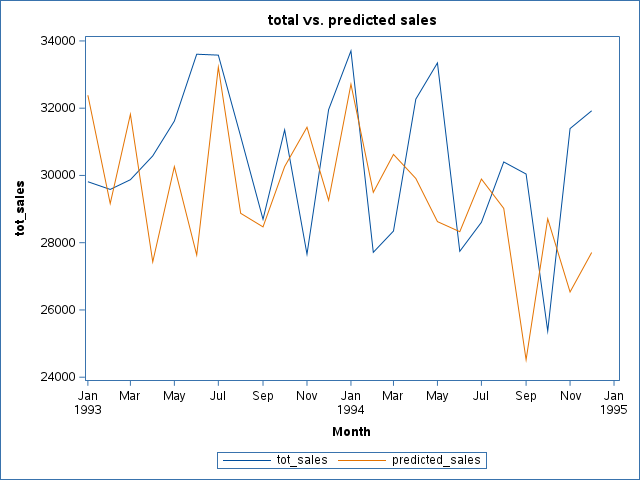

In [6]:
sales.series(y=['tot_sales','predicted_sales'], x='month', title='total vs. predicted sales')

### sql into python pivot routine

In [7]:
sas.submitLOG("""
proc sql;
    create table df as 
    select 
        origin,
        type,
        count(1) as n_cars, 
        avg(msrp) as msrp
    from sashelp.cars
    group by 1, 2
    order by 1, 2;
quit;
"""
)
df = sas.sasdata('df').to_df()
df.columns = df.columns.str.lower()
df.head()


32                                                         The SAS System                          Tuesday, May  7, 2024 01:33:00 PM

231        ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=Plateau; ods
231      !  graphics on / outputfmt=png;
232        
233        
234        proc sql;
235            create table df as
236            select
237                origin,
238                type,
239                count(1) as n_cars,
240                avg(msrp) as msrp
241            from sashelp.cars
242            group by 1, 2
243            order by 1, 2;
244        quit;
245        
246        
247        
248        ods html5 (id=saspy_internal) close;ods listing;
249        

33                                                         The SAS System                          Tuesday, May  7, 2024 01:33:00 PM

250        


,origin,type,n_cars,msrp
0,Asia,Hybrid,3.0,19920.000000
1,Asia,SUV,25.0,29569.000000
2,Asia,Sedan,94.0,22763.968085
3,Asia,Sports,17.0,32510.647059
4,Asia,Truck,8.0,20383.625000


In [8]:
df.pivot(index='origin', columns='type', values='n_cars')

type,Hybrid,SUV,Sedan,Sports,Truck,Wagon
origin,,,,,,
Asia,3.0,25.0,94.0,17.0,8.0,11.0
Europe,NaN,10.0,78.0,23.0,NaN,12.0
USA,NaN,25.0,90.0,9.0,16.0,7.0


In [9]:
df['msrp'] = df['msrp'].astype(int)
pdf = df.pivot(index='origin', columns='type', values='msrp')
pdf

type,Hybrid,SUV,Sedan,Sports,Truck,Wagon
origin,,,,,,
Asia,19920.0,29569.0,22763.0,32510.0,20383.0,23143.0
Europe,NaN,48346.0,42992.0,71998.0,NaN,37851.0
USA,NaN,34589.0,25638.0,45257.0,27220.0,22345.0


<Axes: xlabel='origin'>

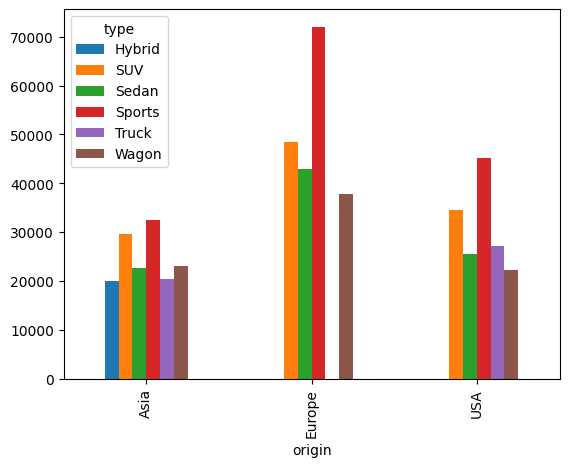

In [10]:
pdf.plot(kind='bar')

### where chaos

In [11]:
sas.submitLST(f"""
proc sql;
    select count(*)
    from sashelp.cars
    where origin = 'Asia';
""")

""
158


In [12]:
sas.submitLST(f"""
data cars;
    set sashelp.cars;
    where origin = 'Asia';
run;
proc freq data=cars;
    tables origin;
run;
""")

Origin,Frequency,Percent,CumulativeFrequency,CumulativePercent
Asia,158,100.00,158,100.00


In [13]:
sas.submitLST(f"""
data cars;
    set sashelp.cars;
    if origin = 'Asia';
run;
proc freq data=cars;
    tables origin;
run;
""")

Origin,Frequency,Percent,CumulativeFrequency,CumulativePercent
Asia,158,100.00,158,100.00


In [14]:
sas.submitLST(f"""
proc freq data=sashelp.cars (where=(origin='Asia'));
    tables origin;
run;
""")

Origin,Frequency,Percent,CumulativeFrequency,CumulativePercent
Asia,158,100.00,158,100.00
